<a href="https://colab.research.google.com/github/DimpleDR/Computational-Data-Science/blob/Projects/Copy_of_M6_SNB_MiniProject_4_Urban_Traffic_Flow_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science

##  A program by IISc and TalentSprint

### Mini Project Notebook: Urban Traffic Flow Prediction using Graph Convolution Network - LSTM

**DISCLAIMER:** THIS NOTEBOOK IS PROVIDED ONLY AS A REFERENCE SOLUTION NOTEBOOK FOR THE MINI-PROJECT. THERE MAY BE OTHER POSSIBLE APPROACHES/METHODS TO ACHIEVE THE SAME RESULTS.

## Learning Objectives

At the end of the Mini Project, you will be able to :

* forecast traffic flow using Graph Convolutional Network and LSTM
* understand the graph structured data and implement the forecasting model

## Information

Accurate and real-time traffic forecasting plays an important role in the Intelligent Traffic System and is important for

- urban traffic planning,
- traffic management, and
- traffic control.

Traffic forecasting is a challenging issue because of the constraints of the urban road network topological structure and the law of dynamic change with time (spatial dependence and temporal dependence). To capture the spatial and temporal dependence simultaneously, a neural network-based traffic forecasting method called the temporal graph convolutional network (T-GCN) model is very useful. It is a combination of the graph convolutional network (GCN) and gated recurrent unit (GRU).

- Specifically, the GCN is used to learn complex topological structures to capture spatial dependence and the gated recurrent unit is used to learn dynamic changes of traffic data to capture temporal dependence. Then, the T-GCN model is employed to traffic forecasting based on the urban road network. T-GCN model can obtain the spatio-temporal correlation from traffic data and the predictions outperform state-of-art baselines on real-world traffic datasets.

Reference: https://arxiv.org/abs/1811.05320

## Dataset



Urban Traffic Prediction from Spatio-Temporal Data Using Deep Meta Learning.

This traffic dataset contains traffic information collected from loop detectors in the highway of Los Angeles County (Jagadish et al., 2014). This dataset contains traffic speeds from Mar-1 to Mar-7, 2012 of 207 sensors, recorded every 5 minutes.  There are 2016 observations (timesteps) of speed records over 207 sensors. Speeds are recorded every 5 minutes. This means that, for a single hour, you will have 12 observations. Similarly, a single day will contain 288 (12x24) observations. Overall, the data consists of speeds recorded every 5 minutes over 207 for 7 days (12X24X7).

Data Source:
https://github.com/lehaifeng/T-GCN/tree/master/data

## Problem Statement

Forecasting urban traffic flow using spatio-temporal data with combined Graph Convolution + LSTM model


## Grading = 10 Points

In [ ]:
#@title Download dataset
!wget -qq https://raw.githubusercontent.com/lehaifeng/T-GCN/master/data/los_adj.csv
!wget -qq https://raw.githubusercontent.com/lehaifeng/T-GCN/master/data/los_speed.csv
!pip -qq install chardet
!pip -qq install git+https://github.com/VenkateshwaranB/stellargraph.git

  Preparing metadata (setup.py) ... done


### Import required packages

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Reshape, Input, RepeatVector, TimeDistributed

from tensorflow.keras.models import Model
#from tensorflow.keras.layers import Dense, LSTM, Reshape, Input
import stellargraph as sg
from stellargraph.layer import GCN
from stellargraph.layer import GCN_LSTM
import networkx as nx

### Data loading and preparation

In [ ]:
sensor_dist_adj = pd.read_csv("/content/los_adj.csv",header=None)
speed_data = pd.read_csv("/content/los_speed.csv").T
sensor_dist_adj = np.mat(sensor_dist_adj)

In [ ]:
speed_data

,0,1,2,3,4,5,6,7,8,9,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
773869,64.375,62.666667,64.000000,61.777778,59.555556,57.333333,66.500,63.625,68.750,63.500,...,64.625,65.444444,63.125,62.875,68.375,65.555556,66.625,66.375,64.666667,66.000
767541,67.625,68.555556,63.750000,65.500000,67.250000,69.000000,63.875,67.250,65.250,61.500,...,67.125,66.555556,68.125,67.125,67.000,65.111111,66.625,66.375,66.555556,67.125
767542,67.125,65.444444,60.000000,62.555556,65.111111,67.666667,67.875,63.250,63.500,62.500,...,66.500,66.222222,67.625,68.625,68.500,64.111111,65.750,63.750,66.888889,66.375
717447,61.500,62.444444,59.000000,59.888889,60.777778,61.666667,62.375,60.500,63.000,58.125,...,55.625,61.000000,58.750,60.625,61.375,61.111111,64.750,63.750,59.888889,59.250
717446,66.875,64.444444,66.500000,66.777778,67.055556,67.333333,64.375,57.375,65.125,66.625,...,65.625,58.000000,66.625,67.125,64.500,66.000000,67.375,67.625,65.111111,64.250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717592,59.375,61.111111,62.500000,59.888889,57.277778,54.666667,62.625,62.375,66.250,64.250,...,63.500,64.555556,65.250,61.625,64.500,55.333333,66.625,65.375,65.222222,62.125
717595,69.000,64.444444,65.625000,65.305556,64.986111,64.666667,65.500,67.500,64.375,66.125,...,65.875,68.666667,67.500,65.875,68.625,67.333333,57.750,68.875,68.222222,68.000
772168,59.250,55.888889,61.375000,60.138889,58.902778,57.666667,51.000,52.000,48.625,50.750,...,58.750,57.777778,56.625,60.250,56.125,62.000000,61.875,60.625,59.444444,58.750
718141,69.000,68.444444,69.857143,69.571429,69.285714,69.000000,69.375,68.625,67.625,66.250,...,69.500,69.222222,69.250,69.125,65.750,64.444444,66.125,69.625,68.333333,68.250


In [ ]:
sensor_dist_adj

matrix([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 1.        , 0.71743792, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.71743792, 1.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         1.        ]])

In [ ]:
num_nodes, time_len = speed_data.shape
print("No. of sensors:", num_nodes, "\nNo of timesteps:", time_len)

No. of sensors: 207 
No of timesteps: 2016


In [ ]:
sensor_dist_adj.shape

(207, 207)

In [ ]:
speed_data.head()

,0,1,2,3,4,5,6,7,8,9,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
773869,64.375,62.666667,64.00,61.777778,59.555556,57.333333,66.500,63.625,68.750,63.500,...,64.625,65.444444,63.125,62.875,68.375,65.555556,66.625,66.375,64.666667,66.000
767541,67.625,68.555556,63.75,65.500000,67.250000,69.000000,63.875,67.250,65.250,61.500,...,67.125,66.555556,68.125,67.125,67.000,65.111111,66.625,66.375,66.555556,67.125
767542,67.125,65.444444,60.00,62.555556,65.111111,67.666667,67.875,63.250,63.500,62.500,...,66.500,66.222222,67.625,68.625,68.500,64.111111,65.750,63.750,66.888889,66.375
717447,61.500,62.444444,59.00,59.888889,60.777778,61.666667,62.375,60.500,63.000,58.125,...,55.625,61.000000,58.750,60.625,61.375,61.111111,64.750,63.750,59.888889,59.250
717446,66.875,64.444444,66.50,66.777778,67.055556,67.333333,64.375,57.375,65.125,66.625,...,65.625,58.000000,66.625,67.125,64.500,66.000000,67.375,67.625,65.111111,64.250


#### Plotting the time series of 10 sensors data

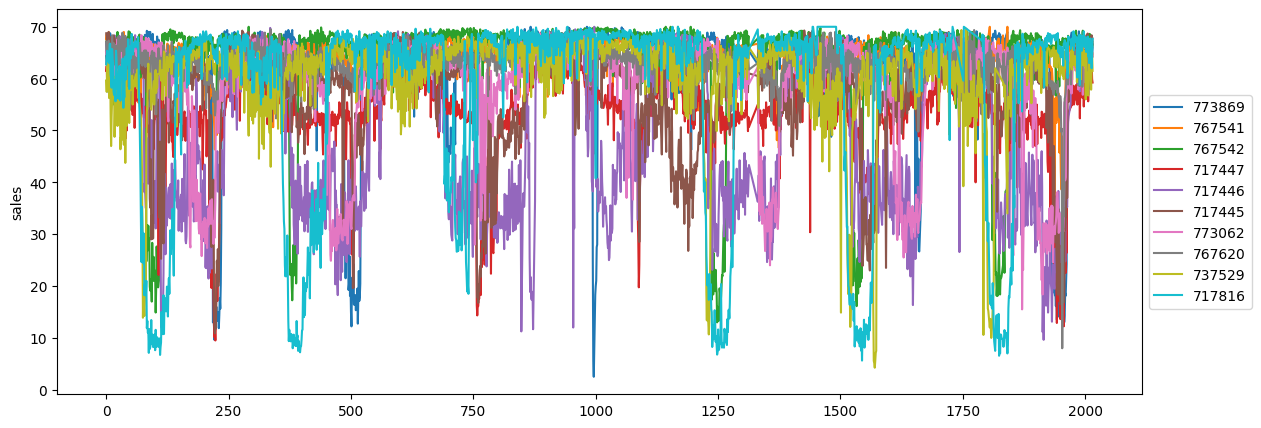

In [ ]:
speed_data.T.iloc[:,:10].plot(figsize=(14,5))
plt.ylabel('sales')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

#### Create and draw the graph of adjacency of matrix

Hint: [link](https://towardsdatascience.com/graph-coloring-with-networkx-88c45f09b8f4)

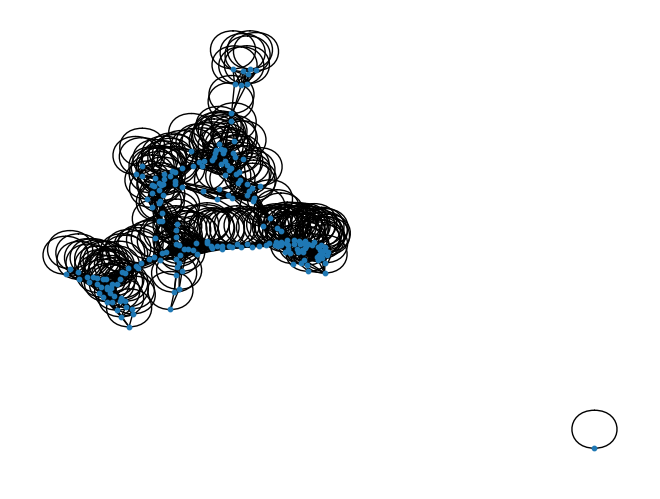

In [ ]:
def show_graph_with_labels(adjacency_matrix):
    rows, cols = np.where(adjacency_matrix > 0)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    nx.draw(gr, node_size=10)#, labels=mylabels, with_labels=True)
    plt.show()

show_graph_with_labels(sensor_dist_adj)

### Preprocessing and train test split

In [ ]:
def train_test_split(data, train_portion):
    time_len = data.shape[1]
    train_size = int(time_len * train_portion)
    train_data = np.array(data.iloc[:,:train_size])
    test_data = np.array(data.iloc[:,train_size:])
    return train_data, test_data
train_rate = 0.8
train_data, test_data = train_test_split(speed_data, train_rate)
print("Train data: ", train_data.shape)
print("Test data: ", test_data.shape)

Train data:  (207, 1612)
Test data:  (207, 404)


In [ ]:
def scale_data(train_data, test_data):
    max_speed = train_data.max()
    min_speed = train_data.min()
    train_scaled = (train_data - min_speed) / (max_speed - min_speed)
    test_scaled = (test_data - min_speed) / (max_speed - min_speed)
    return train_scaled, test_scaled
train_scaled, test_scaled = scale_data(train_data, test_data)

#### Prepare Time series data


Aim is to use 50 minutes of historical speed observations to predict the speed in future (1 hour ahead)

* Choose windows of 10 historical observations i.e. 5 * 10 = 50 minutes (`seq_len`) for each segment as the input and use it to predict the speed after 5 * 12 = 60 minutes (target) using the sliding window approach.

**Note:**
The below parameters
-  `seq_len` is the size of the past window of information.
- `pre_len` is future prediction ( 1 hour in future = 12 * 5 minutes)



Steps:

* Prepare the data to be fed into an LSTM. The LSTM model learns a function that maps a **sequence of past observations as input to an output observation**, so the sequence of observations must be transformed into multiple examples from which the LSTM can learn.

* Choose to use 50 minutes of historical speed observations to predict the speed in future (eg. 1 hour ahead). First reshape the timeseries data into windows of 10 historical observations for each segment as the input and the speed 60 minutes later as the prediction label. This can be performed using a sliding window approach:

    - Starting from the beginning of the timeseries, we take the first 10 speed records as the 10 input features and the speed 12 timesteps head (60 minutes) as the speed we want to predict.

    - Shift the timeseries by one timestep and take the 10 observations from the current point as the input features and the speed one hour ahead as the output to predict.

    - Keep shifting by 1 timestep and picking the 10 timestep window from the current time as input feature and the speed one hour ahead of the 10th timestep as the output to predict, for the entire data.

  *Note: The above steps are done for each sensor.*

The function below returns the above transformed timeseries data for the model to train on. The parameter seq_len is the size of the past window of information. The pre_len is how far in the future does the model need to learn to predict.

Each **training observation** is 10 historical speeds **(seq_len).**

Each **training prediction** is the speed 60 minutes later **(pre_len).**

In [ ]:
seq_len = 10
pre_len = 12
def sequence_data_preparation(seq_len, pre_len, train_data, test_data):
    trainX, trainY, testX, testY = [], [], [], []
    for i in range(train_data.shape[1] - int(seq_len + pre_len - 1)):
        a = train_data[:, i : i + seq_len + pre_len]
        trainX.append(a[:,:seq_len])
        trainY.append(a[:,-1])

    for i in range(test_data.shape[1] - int(seq_len + pre_len - 1)):
        b = test_data[:,i : i + seq_len + pre_len]
        testX.append(b[:,:seq_len])
        testY.append(b[:,-1])
    return np.array(trainX), np.array(trainY), np.array(testX), np.array(testY)

trainX, trainY, testX, testY = sequence_data_preparation(seq_len, pre_len, train_scaled, test_scaled)
trainX.shape, trainY.shape, testX.shape, testY.shape,

((1591, 207, 10), (1591, 207), (383, 207, 10), (383, 207))

### Build and Train the LSTM model and plot the loss results

In [ ]:
inp = Input(shape=(207, 10))
x = LSTM(200, activation='tanh')(inp)
x = RepeatVector(200)(x)
x = LSTM(200, activation='tanh')(x)
out = Dense(207)(x)
model_lstm = Model(inp, out)
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 207, 10)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 200)                 │         168,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 200, 200)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 200)                 │         320,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 207)                 │          41,607 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 531,207 (2.03 MB)

 Trainable params: 531,207 (2.03 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
hist = model_lstm.fit(x = trainX,y= trainY, epochs=10, validation_data=(testX, testY))

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.2315 - val_loss: 0.0342
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0234 - val_loss: 0.0332
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0230 - val_loss: 0.0325
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0245 - val_loss: 0.0340
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0233 - val_loss: 0.0434
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0256 - val_loss: 0.0343
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0247 - val_loss: 0.0333
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0236 - val_loss: 0.0335
Epoch 9/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0242 - val_loss: 0.0323
Epoch 10/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0225 - val_loss: 0.0316


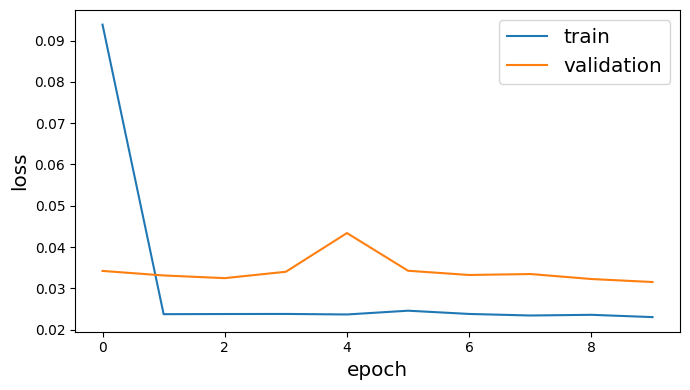

In [ ]:
sg.utils.plot_history(hist)

### StellarGraph Graph Convolution and LSTM model ( 3 points)

In order to use the model, we need:

* An **N by N** adjacency matrix, which describes the distance relationship between the N sensors,

* An **N by T** feature matrix, which describes the ($f_1, .., f_T$) speed records over T timesteps for the N sensors.

Arguments of GCN_LSTM:
  - seq_len: No. of LSTM cells

  - adj: unweighted/weighted adjacency matrix

  - gc_layer_sizes (list of int): Output sizes of Graph Convolution  layers in the stack.

  - lstm_layer_sizes (list of int): Output sizes of LSTM layers in the stack.

  - gc_activations (list of str or func): Activations applied to each layer's output.

  - lstm_activations (list of str or func): Activations applied to each layer's output; defaults to ``['tanh', ..., 'tanh']``.

In [ ]:
# Define the GCN_LSTM class
class GCN_LSTM:
    def __init__(self, seq_len, adj, gc_layer_sizes, gc_activations, lstm_layer_sizes, lstm_activations):
        self.seq_len = seq_len
        self.adj = adj
        self.gc_layer_sizes = gc_layer_sizes
        self.gc_activations = gc_activations
        self.lstm_layer_sizes = lstm_layer_sizes
        self.lstm_activations = lstm_activations

    def in_out_tensors(self):
        from tensorflow.keras.layers import Input, LSTM, Dense
        from tensorflow.keras.models import Model

        # Input layer
        x_input = Input(shape=(self.seq_len, self.adj.shape[0]))

        # Graph convolution layers
        x = x_input
        for size, activation in zip(self.gc_layer_sizes, self.gc_activations):
            x = Dense(size, activation=activation)(x)

        # LSTM layers
        for size, activation in zip(self.lstm_layer_sizes, self.lstm_activations):
            x = LSTM(size, activation=activation, return_sequences=True)(x)

        # Output layer
        x_output = Dense(self.adj.shape[0])(x)

        return x_input, x_output

In [ ]:
# Define adjacency matrix (example)
seq_len = 12
sensor_dist_adj = np.random.rand(10, 10)  # Replace with actual adjacency matrix

In [ ]:
# Initialize the GCN_LSTM model
gcn_lstm = GCN_LSTM(
    seq_len=seq_len,
    adj=sensor_dist_adj,
    gc_layer_sizes=[16, 10],
    gc_activations=["relu", "relu"],
    lstm_layer_sizes=[200, 200],
    lstm_activations=["tanh", "tanh"],
)

In [ ]:
# Get input and output tensors
x_input, x_output = gcn_lstm.in_out_tensors()
x_input.shape

(None, 12, 10)

In [ ]:
# Adjust the input shape to match the data (207 features, seq_len=10)
x_input = Input(shape=(10, 207))  # Adjusted input shape for the features
x = x_input

In [ ]:
for size, activation in zip(gcn_lstm.gc_layer_sizes, gcn_lstm.gc_activations):
    x = TimeDistributed(Dense(size, activation=activation))(x)

# LSTM Layers
for size, activation in zip(gcn_lstm.lstm_layer_sizes, gcn_lstm.lstm_activations):
    x = LSTM(size, activation=activation, return_sequences=True)(x)

# Optional: Aggregate sequence output from LSTM (if only one output vector is needed)
x = LSTM(gcn_lstm.lstm_layer_sizes[-1], activation=gcn_lstm.lstm_activations[-1], return_sequences=False)(x)

# Output Layer: Match trainY's shape (207 features)
x_output = Dense(207)(x)

In [ ]:
# Build and compile the model
model = Model(inputs=x_input, outputs=x_output)
model.compile(optimizer="adam", loss="mae", metrics=["mse"])

In [ ]:
# Model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 10, 207)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 10, 16)              │           3,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 10, 10)              │             170 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 10, 200)             │         168,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 10, 200)             │         320,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 200)                 │         320,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 207)                 │          41,607 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 855,505 (3.26 MB)

 Trainable params: 855,505 (3.26 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# from tensorflow.keras import backend as K
# K.clear_session()

In [ ]:
# Ensure trainX and testX have the correct shape: (batch_size, time_steps, features)
# Swap axes if the data is incorrectly shaped as (batch_size, features, time_steps)
trainX = np.transpose(trainX, (0, 2, 1)) if trainX.shape[1] == 207 else trainX
testX = np.transpose(testX, (0, 2, 1)) if testX.shape[1] == 207 else testX

# Verify data shapes
print(f"trainX shape: {trainX.shape}")  # Should be (num_samples, 10, 207)
print(f"trainY shape: {trainY.shape}")  # Should match output size (num_samples, 207)
print(f"testX shape: {testX.shape}")
print(f"testY shape: {testY.shape}")

trainX shape: (1591, 10, 207)
trainY shape: (1591, 207)
testX shape: (383, 10, 207)
testY shape: (383, 207)


In [ ]:
model = Model(inputs=x_input, outputs=x_output)

# Compile the model
model.compile(optimizer="adam", loss="mae", metrics=["mse"])

# Model summary
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 10, 207)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 10, 16)              │           3,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 10, 10)              │             170 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 10, 200)             │         168,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 10, 200)             │         320,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 200)                 │         320,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 207)                 │          41,607 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 855,505 (3.26 MB)

 Trainable params: 855,505 (3.26 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(trainX, trainY, epochs=100, batch_size=60, validation_data=(testX, testY))

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.5136 - mse: 0.3918 - val_loss: 0.1194 - val_mse: 0.0411
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0908 - mse: 0.0264 - val_loss: 0.1066 - val_mse: 0.0407
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0844 - mse: 0.0274 - val_loss: 0.1066 - val_mse: 0.0415
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0820 - mse: 0.0260 - val_loss: 0.1054 - val_mse: 0.0405
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0827 - mse: 0.0265 - val_loss: 0.1052 - val_mse: 0.0398
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0829 - mse: 0.0264 - val_loss: 0.1049 - val_mse: 0.0397
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0819 - mse: 0.0259 - val_loss: 0.1044 - val_mse: 0.0386
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0816 - mse: 0.0253 - val_loss: 0.1029 - val_mse: 0.0361
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - lo

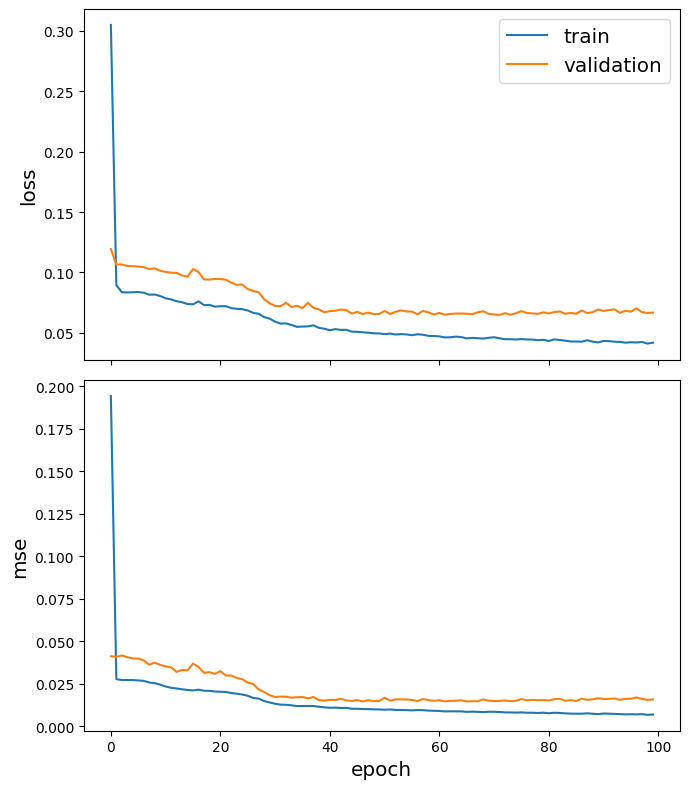

In [ ]:
sg.utils.plot_history(history)

In [ ]:
ythat = model.predict(trainX)
yhat = model.predict(testX)

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [ ]:
trainX.shape, testX.shape

((1591, 10, 207), (383, 10, 207))

#### Rescale values
Rescale the predicted values to the original value range of the timeseries.

In [ ]:
## Rescale values
max_speed = train_data.max()
min_speed = train_data.min()

## actual train and test values
train_rescref = np.array(trainY * max_speed)
test_rescref = np.array(testY * max_speed)
## Rescale model predicted values
train_rescpred = np.array((ythat) * max_speed)
test_rescpred = np.array((yhat) * max_speed)

In [ ]:
test_rescref.shape

(383, 207)

In [ ]:
print("Shape of testX[0]:", testX[0].shape)

Shape of testX[0]: (10, 207)


In [ ]:
# Ensure the correct feature dimension and sequence length
sequence_length = trainX.shape[1]  # Length of the sequence (e.g., 207)
n_features = trainX.shape[2]       # Number of features (e.g., 10, 16, etc.)

# Reshape the test sample to match the expected input shape
onetest_sample = testX[0].reshape(1, sequence_length, n_features)

# Verify the shape
print("Reshaped onetest_sample shape:", onetest_sample.shape)

Reshaped onetest_sample shape: (1, 10, 207)


In [ ]:
# Predict using the correctly shaped sample
onesample_pred = model.predict(onetest_sample)

# Print the prediction result and its shape
print("Prediction shape:", onesample_pred.shape)
print("Prediction result:", onesample_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Prediction shape: (1, 207)
Prediction result: [[0.942873   0.9276908  0.9544917  0.7417205  0.5828363  0.85560334
  0.66870487 0.8781005  0.91869557 0.94855523 0.8741261  0.8755111
  0.24758449 0.95857036 0.78004843 0.5320273  0.35594612 0.82114553
  0.77690727 0.7397454  0.98136014 0.8871731  0.69879687 0.85431844
  0.90693027 0.86954236 0.5167321  0.887702   0.98068196 0.6278318
  0.8280236  0.9450778  0.94587386 0.81142884 0.90327764 0.90096265
  0.96692145 0.9604117  0.8475527  0.75972855 0.9203193  0.87091625
  0.89032304 0.9079544  0.97757035 0.94993836 0.8927122  0.79228354
  0.80469316 0.8737522  0.8773439  0.62353927 0.8306553  0.75222117
  0.87803566 0.84356606 0.55443376 0.762972   0.9051426  0.8802533
  0.83270055 0.8658079  0.93037003 0.7415406  0.93186086 0.8773657
  0.93292737 0.96183574 0.96697754 0.8122649  0.9006237  0.81209546
  0.8024864  0.6281825  0.8905861  0.6038943  0.69697404 0.9360483
  0.955926   0.95544904 0.9165531  0.

### Plot the predictions and Loss of each sensors

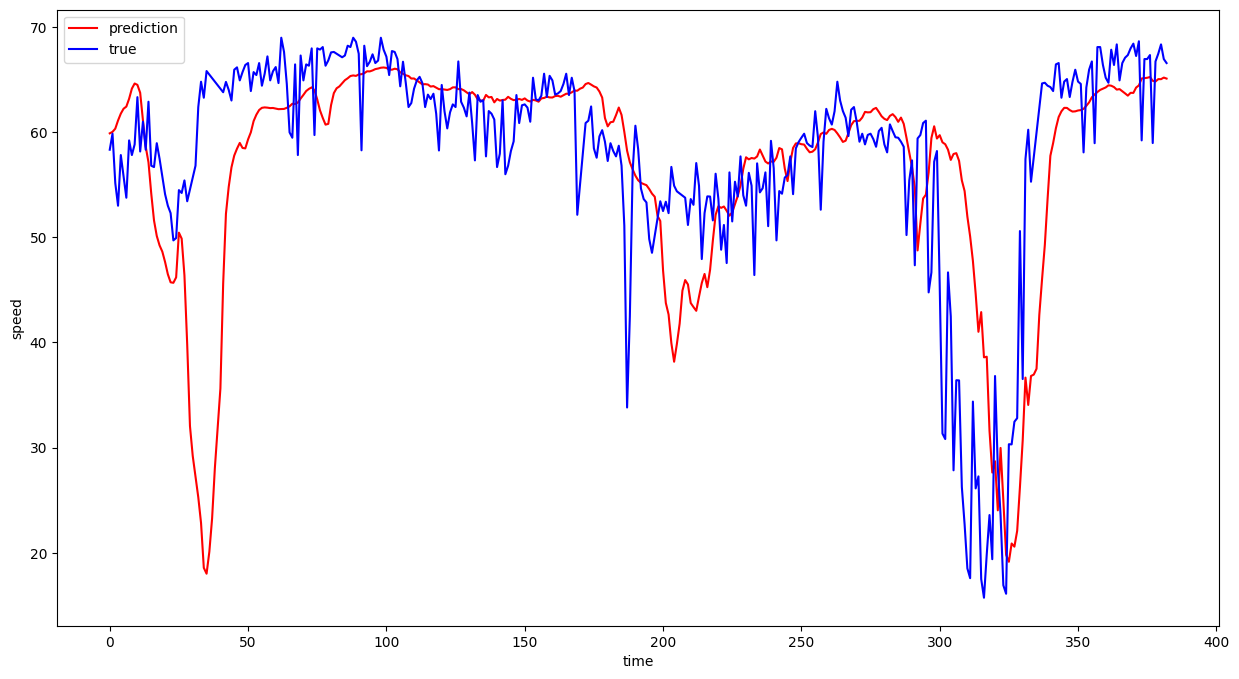

In [ ]:
##all test result visualization
fig1 = plt.figure(figsize=(15, 8))
#    ax1 = fig1.add_subplot(1,1,1)
a_pred = test_rescpred[:, 5]
a_true = test_rescref[:, 5]
plt.plot(a_pred, "r-", label="prediction")
plt.plot(a_true, "b-", label="true")
plt.xlabel("time")
plt.ylabel("speed")
plt.legend(loc="best", fontsize=10)
plt.show()

Error plotting for all the sensors

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse_sensors, mae_sensors = [],[]
for sensor in range(test_rescpred.shape[1]):
  a_pred = test_rescpred[:, sensor]
  a_true = test_rescref[:, sensor]
  mse_sensors.append(mean_squared_error(a_true, a_pred))
  mae_sensors.append(mean_absolute_error(a_true, a_pred))

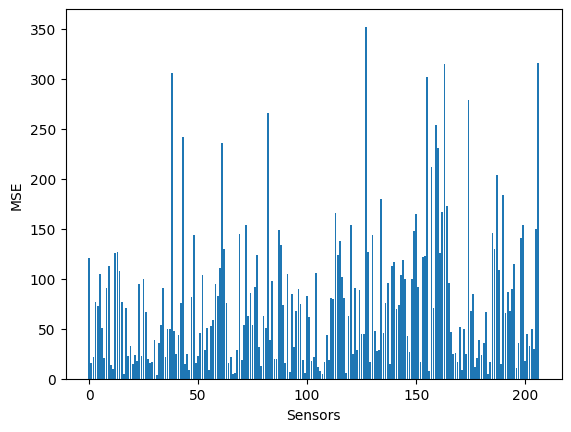

In [ ]:
# mse bar plot
plt.bar(range(207),mse_sensors)
plt.xlabel("Sensors")
plt.ylabel("MSE")
plt.show()

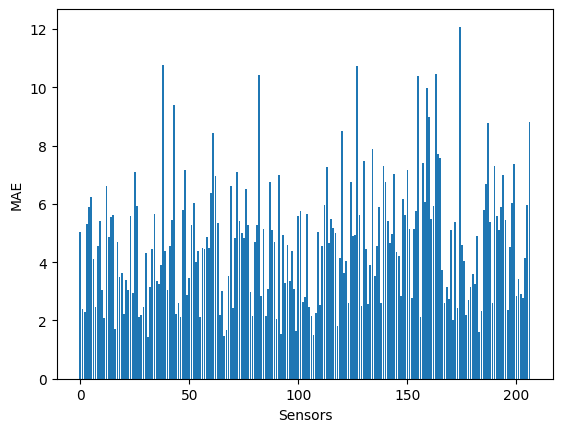

In [ ]:
# mae bar plot
plt.bar(range(207),mae_sensors)
plt.xlabel("Sensors")
plt.ylabel("MAE")
plt.show()

#### Report Analysis

  * Discuss: Why is this called a spatio-temporal problem?

  * Discuss: In what way is GCN-LSTM more useful for the traffic prediction task than LSTM?